In [1]:
%reset -f
import numpy as np
import pandas as pd


import matplotlib
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import matplotlib.pyplot as plt
import re, sqlite3, pickle, time, datetime, random

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
path  = r'/rfs/CAPAI_PhD_dflr2/Shared/Data/output/20220221_'
file9 = path + 'spin.txt'
df_spin  = pd.read_csv(file9, sep='\t', lineterminator='\n')
df_spin['date_time_arrived'] = pd.to_datetime(df_spin['date_time_arrived'], format='%Y-%m-%d %H:%M:%S')


In [3]:
df_spin.head(4)

,patient_id,date_time_arrived,cxr_4h,cxr_cap,cxr_date,cxr_time,o2_1h,o2_prescribed_1h,curb65_recorded,curb65_score,ab_4h,reason_ab_not_concordant,ab_severity,ab_date_time\r
0,45502669,2019-01-02 15:46:00,Y,Y,2019-01-02,16:14,Y,N,Y,0.000,Y,NaN,Y,2019-01-02 17:00:00\r
1,70844377,2019-01-03 11:47:00,N,Y,2018-12-31,11:54,Y,N,Y,0.000,Y,2.000,Y,2019-01-03 14:00:00\r
2,43194461,2019-01-02 10:15:00,Y,Y,2019-01-02,10:31,Y,N,Y,0.000,Y,2.000,Y,2019-01-02 12:20:00\r
3,31229217,2019-01-01 05:28:00,Y,Y,0000-00-00,NaN,Y,Y,Y,1.000,Y,NaN,Y,2019-01-01 06:10:00\r


In [4]:
############################################################
# LOADING ADMISSIONS AND PATIENTS DF
############################################################
data = pickle.load( open('DataFrame_pickles/df_patients_admissions_2019_2020.pickle', 'rb'))
df_patients   = data[0]
df_admissions = data[1]


In [5]:
df_admissions.head(4)

,admission_id,episode_diagnoses,patient_id,age_at_admission\r,admission_date_time,admission_date_code_time,discharge_date_time,discharge_date_code_time,lengthofstay,isPneumonia,mortal_admin,icu_count\r,Comorbidity_score
3,99645131,"||E10.5,L97.X,L08.9,R02.X,A41.9,R65.1,N17.9,E1...",18026138,55,2021-11-25 16:34:00,18956.690,2021-12-31 14:48:00,18992.617,35 days 22:14:00,1,0,0,2
4,21362780,"||U07.1,J12.8,B97.2,J15.9,B97.2,Z86.7||U07.1,J...",27754209,45,2021-11-12 17:21:00,18943.723,2021-11-20 14:00:00,18951.583,7 days 20:39:00,1,0,0,0
5,13991116,"||A41.9,U07.1,J12.8,B97.2,K75.0,K92.0,J90.X,I8...",54047888,70,2020-04-20 21:48:00,18372.908,2020-05-20 05:30:00,18402.229,29 days 07:42:00,1,1,0,1
6,58580641,"||U07.2,J12.8,E11.9,Z86.1",56373663,66,2020-05-21 08:05:00,18403.337,2020-05-21 15:07:00,18403.630,0 days 07:02:00,1,0,0,1


# Filtering Data

In [6]:
list_patients = df_spin[(~(df_spin['curb65_score'].isna())) & 
                        (df_spin['patient_id'].isin(df_patients['patient_id'].unique()))]['patient_id'].unique()
df = df_admissions[df_admissions['patient_id'].isin(list_patients)][['patient_id', 'lengthofstay']].copy()

print('number of patients with Curb65 information', len(list_patients))
print('number of admissions in df', len(df))

number of patients with Curb65 information 2025
number of admissions in df 2714


In [7]:
path  = r'/rfs/CAPAI_PhD_dflr2/Shared/Data/output/20220221_'
file1 = path + 'admissions.txt' 
df_admin = pd.read_csv(file1, sep='\t', lineterminator='\n')

In [8]:
df

,patient_id,lengthofstay
8,995938,10 days 13:52:00
9,6081496,30 days 08:29:00
10,6081496,5 days 17:49:00
13,37605233,6 days 06:19:00
14,37605233,4 days 19:38:00
...,...,...
24702,63610844,10 days 04:13:00
24705,59288085,11 days 16:07:00
24711,67793747,6 days 01:11:00
24712,67793747,0 days 04:39:00


In [9]:
df_ = []

def pruebas(temp_spin, temp_admn, dt):
    ls = []
    for idx,curb_record in temp_spin.iterrows():
        time_crb  = curb_record['date_time_arrived']
        curb = curb_record['curb65_score']
        #dt        = datetime.timedelta(days=1)
        admn_cand = temp_admn[(temp_admn['admission_date_time'] < (time_crb + dt) ) &
                              (temp_admn['discharge_date_time'] > (time_crb - dt) ) ]
        if len(admn_cand) == 0: 
            continue
        if len(admn_cand) == 1:
            admn = admn_cand['admission_id'].iloc[0]
            age  = admn_cand['age_at_admission\r'].iloc[0]
            los  = admn_cand['lengthofstay'].iloc[0]
            los_d = los.days + round((los.seconds/(60*60*24))*2)/2
            ls.append([admn, patient, curb, age, los_d])
        else:
            #print('puta')
            ls = pruebas(temp_spin, temp_admn, datetime.timedelta(days=0.1))
            return(ls)
            break
    return ls
error = 0
for patient in list_patients:
    temp_spin = df_spin[df_spin['patient_id'] == patient]
    temp_admn = df_admissions[df_admissions['patient_id'] == patient]
    a =1
    if temp_admn['mortal_admin'].iloc[0] == 1:
        admin_date = temp_admn['admission_date_time'].iloc[0]
        death_date = df_patients[df_patients['patient_id'] == patient].iloc[0]['date_of_death']
        time_to_death = death_date - admin_date
        # Length to death
        ltd = time_to_death.days + round((time_to_death.seconds/(60*60*24))*2)/2
    else:
        ltd = np.nan
    if (len(temp_spin) == 1) and (len(temp_admn) ==1):
        curb = temp_spin['curb65_score'].iloc[0]
        los  = temp_admn['lengthofstay'].iloc[0]
        age  = temp_admn['age_at_admission\r'].iloc[0]
        admn = temp_admn['admission_id'].iloc[0]
        los_d = los.days + round((los.seconds/(60*60*24))*2)/2
        
        df_.append([admn, patient, curb, age, los_d, ltd])
    else:
        ls = pruebas(temp_spin, temp_admn, datetime.timedelta(days=1.5))
        
        if len(ls) == 0:
            error = error +1 
            #break
print('number of errors:', error)                

number of errors: 110


In [10]:
df = pd.DataFrame(df_, columns =['admission', 'patient', 'curb','age','los', 'ltd'])
df.head(5)

,admission,patient,curb,age,los,ltd
0,40037580,73587963,0.000,59,32.500,NaN
1,74654337,46823261,2.000,84,14.500,20.000
2,69639051,57744947,0.000,61,6.500,NaN
3,7175893,51402009,2.000,91,9.000,NaN
4,34597618,46301726,2.000,54,66.000,NaN


<AxesSubplot:>

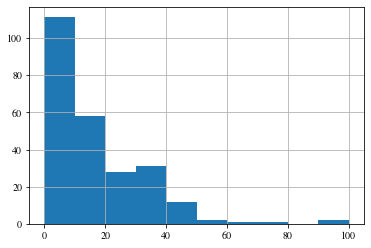

In [11]:
df['ltd'].hist()

In [12]:
list_mortal_admins = df_admissions[df_admissions['mortal_admin'] == 1]['admission_id'].unique()
print('total admins in survival analysis',len(df))
print('admins where patient deceased',len(df[df['admission'].isin(list_mortal_admins )]))



total admins in survival analysis 1365
admins where patient deceased 246


# CURB

In [13]:
dict_df_curb = {}

int_days = 25

columns = ['time_days','curb_0', 'curb_1','curb_2','curb_3','curb_4', 'curb_5']
time = [i for i in np.linspace(0, int_days, int_days*2 +1)]
dict_df_curb[columns[0]] = time
for i in range(6):
    df_temp = df[df['curb']==i]
    tot_pat = len(df_temp)
    df_temp_mort = df_temp[~df_temp['ltd'].isna()]
    
    ls_curb = [(tot_pat - len(df_temp_mort[df_temp_mort['ltd']<t])) / tot_pat for t in time]
    dict_df_curb[columns[i+1]] = ls_curb 
df_curb = pd.DataFrame(dict_df_curb)

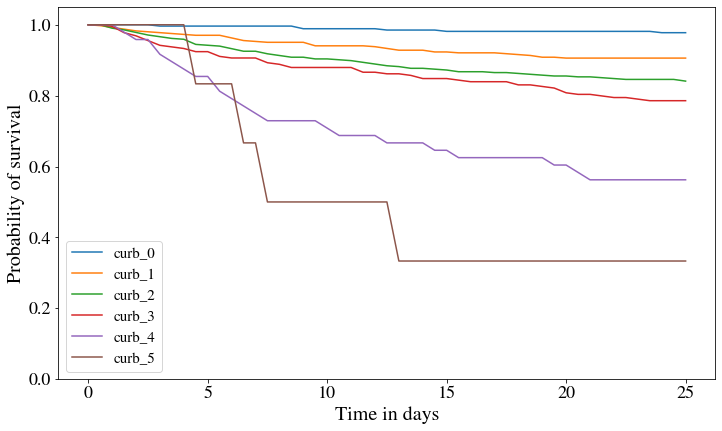

In [14]:


plt.figure(figsize=(10,6))
for col in columns[1:]:
    plt.plot(df_curb[columns[0]], df_curb[col], label = col)
plt.ylabel('Probability of survival', fontsize = 20)
plt.xlabel('Time in days', fontsize = 20)
plt.legend()
plt.tight_layout()
plt.ylim((0.0,1.05))
plt.tick_params(axis='both', labelsize=18)
plt.legend(fontsize = 15)
plt.savefig('Survival_analysis_Curb_19_20.png', transparent = True, bbox_inches = "tight")
plt.show()

# ADMISSIONS WITH DEAD PATIENT

dict_df_curb = {}


int_days = 15

columns = ['time_days','curb_0', 'curb_1','curb_2','curb_3','curb_4', 'curb_5']
time = [i for i in np.linspace(0, int_days, int_days*2 +1)]
dict_df_curb[columns[0]] = time
for i in range(6):
    df_temp = df[(df['curb']==i) & (df['admission'].isin(list_mortal_admins ))]
    
    ls_curb = [1 - (len(df_temp[df_temp['los']< t])/len(df_temp)) for t in time]
    dict_df_curb[columns[i+1]] = ls_curb 
df_curb = pd.DataFrame(dict_df_curb) 


plt.figure(figsize=(10,6))
for col in columns[1:]:
    plt.plot(df_curb[columns[0]], df_curb[col], label = col)
plt.ylabel('Probability of survival', fontsize = 20)
plt.xlabel('Time in days', fontsize = 20)
plt.legend()
plt.tight_layout()
plt.ylim((0.0,1.05))
plt.tick_params(axis='both', labelsize=18)
plt.legend(fontsize = 15)
plt.savefig('Survival_analysis_Curb_deceased_19_20.png', transparent = True, bbox_inches = "tight")
plt.show()

# AGE

In [15]:
dict_df_age = {}


int_days = 20

columns = ['time_days','<=65', '>65']
time = [i for i in np.linspace(0, int_days, int_days*2 +1)]
dict_df_age[columns[0]] = time

df_temp = df[(df['age']<=65)]
tot_pat = len(df_temp)
df_temp_mort = df_temp[~df_temp['ltd'].isna()]
ls_age = [(tot_pat - len(df_temp_mort[df_temp_mort['ltd']<t])) / tot_pat for t in time]
#ls_age  = [1 - (len(df_temp[df_temp['los']< t])/len(df_temp)) for t in time]
dict_df_age[columns[1]] = ls_age

df_temp = df[(df['age']>65)]
tot_pat = len(df_temp)
df_temp_mort = df_temp[~df_temp['ltd'].isna()]
ls_age = [(tot_pat - len(df_temp_mort[df_temp_mort['ltd']<t])) / tot_pat for t in time]
#ls_age  = [1 - (len(df_temp[df_temp['los']< t])/len(df_temp)) for t in time]
dict_df_age[columns[2]] = ls_age


df_age = pd.DataFrame(dict_df_age) 
len(df_age)

41

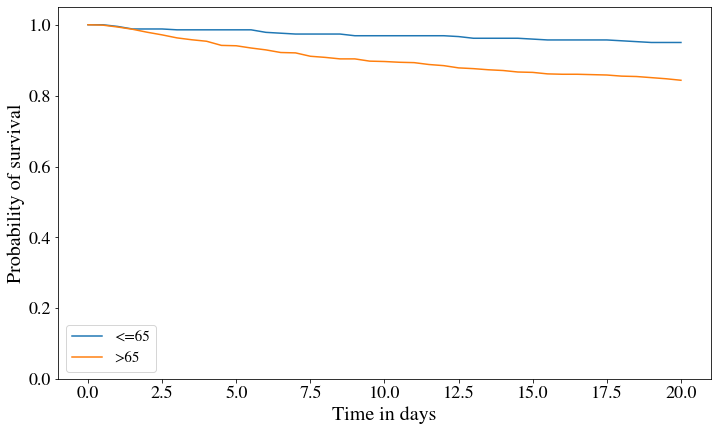

In [16]:

plt.figure(figsize=(10,6))
for col in columns[1:]:
    plt.plot(df_age[columns[0]], df_age[col], label = col)
plt.ylabel('Probability of survival', fontsize = 20)
plt.xlabel('Time in days', fontsize = 20)
plt.legend()
plt.tight_layout()
plt.ylim((0.0,1.05))
plt.tick_params(axis='both', labelsize=18)
plt.legend(fontsize = 15)
plt.savefig('Survival_analysis_Age_19_20.png', transparent = True, bbox_inches = "tight")
plt.show()

# ADMISSIONS WITH DEAD PATIENT


dict_df_age = {}


int_days = 15

columns = ['time_days','<=65', '>65']
time = [i for i in np.linspace(0, int_days, int_days*2 +1)]
dict_df_age[columns[0]] = time

df_temp = df[(df['age']<=65) & (df['admission'].isin(list_mortal_admins ))]
ls_age  = [1 - (len(df_temp[df_temp['los']< t])/len(df_temp)) for t in time]
dict_df_age[columns[1]] = ls_age

df_temp = df[(df['age']>65) & (df['admission'].isin(list_mortal_admins ))]
ls_age  = [1 - (len(df_temp[df_temp['los']< t])/len(df_temp)) for t in time]
dict_df_age[columns[2]] = ls_age


df_age = pd.DataFrame(dict_df_age) 



plt.figure(figsize=(10,6))
for col in columns[1:]:
    plt.plot(df_age[columns[0]], df_age[col], label = col)
plt.ylabel('Probability of survival', fontsize = 20)
plt.xlabel('Time in days', fontsize = 20)
plt.legend()
plt.tight_layout()
plt.ylim((0.0,1.05))
plt.tick_params(axis='both', labelsize=18)
plt.legend(fontsize = 15)
plt.savefig('Survival_analysis_Age_deceased_19_20.png', transparent = True, bbox_inches = "tight")
plt.show()